In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import lightgbm as lgb

import shap


# Exploration, analyse et visualisation des resulats par le meilleur modele
Dans ce notebook, on genere les jeux de donnees et graphiques necessaires pour le dashboard

## 1- Upload des jeux de donnees et du modele

In [2]:
X_train=pd.read_csv('X_train.csv')
X_test=pd.read_csv('X_test.csv')
y_train=pd.read_csv('y_train.csv')
y_test=pd.read_csv('y_test.csv')
id_test=pd.read_csv("id_test.csv")

In [3]:
model, best_th=pickle.load(open('lgbm_model_custom_noscale_best_th.pkl','rb'))

Trying to unpickle estimator LabelEncoder from version 1.1.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [4]:
model

LGBMClassifier(class_weight='balanced', colsample_bytree=0.5593633628418209,
               learning_rate=0.020458228563059816, n_estimators=536, n_jobs=1,
               objective='binary', random_state=42,
               reg_alpha=0.0008969198878085443, reg_lambda=0.5541512751797301,
               scale_pos_weight=1, subsample=0.7172135904402763)

## 2- Feature importances du modele

In [21]:
features=X_train.columns

In [22]:
val=model.feature_importances_
imp=pd.DataFrame({'Features': features, 'Importances' : val})
imp=imp.sort_values(by='Importances', ascending=False)
imp

,Features,Importances
203,PAYMENT_RATE,678
29,EXT_SOURCE_2,556
30,EXT_SOURCE_3,427
9,DAYS_BIRTH,316
6,AMT_ANNUITY,268
...,...,...
109,OCCUPATION_TYPE_Low-skill Laborers,0
165,ORGANIZATION_TYPE_Security,0
62,FLAG_DOCUMENT_21,0
107,OCCUPATION_TYPE_IT staff,0


In [23]:
imp.to_csv('importances.csv', index=False)

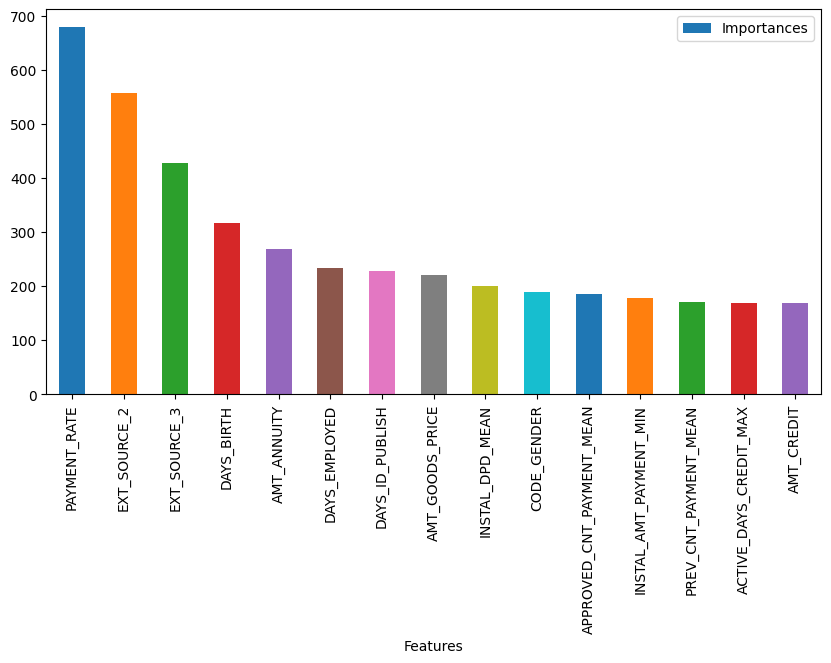

In [95]:
#fig=plt.figure(figsize=(5, 50))
test=imp.head(15)
feat=test.Features.values
test.plot.bar(x='Features', y='Importances', figsize=(10,5), color=sns.color_palette())
plt.savefig('importance.png')

In [61]:
top10_feat=imp.head(10).Features.values

In [44]:
list(top10_feat)


['PAYMENT_RATE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'AMT_GOODS_PRICE',
 'INSTAL_DPD_MEAN',
 'CODE_GENDER']

In [6]:
pickle.dump((top10_feat), open('top10_feat.pkl', 'wb'))

## 3- Generation des quantiles des 10 meilleurs variables du modele

### On ajoute la liste des identifiant clients au jeu de donnee

In [7]:
df=X_test.join(id_test)

In [8]:
df=df.join(y_test)

### Generation des indicateurs de distribution statistiques des variables

In [93]:
desc=df[top10_feat].describe().transpose()
desc

,count,mean,std,min,25%,50%,75%,max
PAYMENT_RATE,101478.0,0.053724,0.022546,0.022073,0.036836,0.050000,0.064061,1.244278e-01
EXT_SOURCE_2,101478.0,0.514390,0.190686,0.000001,0.393102,0.565961,0.662953,8.549997e-01
EXT_SOURCE_3,101478.0,0.515325,0.174754,0.000527,0.415347,0.535276,0.634706,8.939761e-01
DAYS_BIRTH,101478.0,-16049.830318,4362.168340,-25229.000000,-19701.000000,-15755.000000,-12448.000000,-7.680000e+03
AMT_ANNUITY,101478.0,27094.350293,14447.259601,1980.000000,16516.125000,24916.500000,34596.000000,2.250000e+05
DAYS_EMPLOYED,101478.0,-2248.363675,2123.858458,-17912.000000,-2763.000000,-1648.000000,-936.000000,0.000000e+00
DAYS_ID_PUBLISH,101478.0,-3003.386626,1508.543522,-6383.000000,-4304.000000,-3273.000000,-1734.000000,0.000000e+00
AMT_GOODS_PRICE,101478.0,537720.181990,367960.834789,45000.000000,238500.000000,450000.000000,679500.000000,4.050000e+06
INSTAL_DPD_MEAN,101478.0,1.001767,7.351324,0.000000,0.000000,0.038462,0.466667,9.606667e+02
CODE_GENDER,101478.0,0.658961,0.474061,0.000000,0.000000,1.000000,1.000000,1.000000e+00


In [94]:
minmax=desc.drop(columns=['count', 'mean', 'std'])
minmax=minmax.transpose()

In [95]:
minmax.to_csv('minmax.csv', index=False)


### Remarque:
Ce jeu de donnees sera utilise pour situe un client donne par rapport aux autres clients

###  Representation graphique de la situation d'un client par rapport aux autres clients

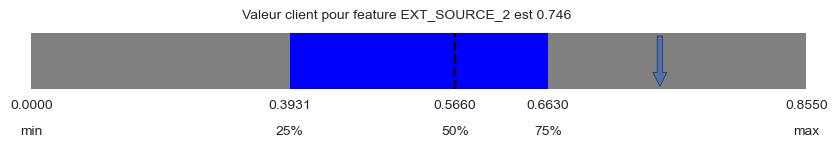

In [98]:
from matplotlib.patches import Rectangle, FancyArrowPatch
client=df.loc[3]
feature='EXT_SOURCE_2'
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(10, 2))
fig.subplots_adjust(bottom=0.6)
fig.suptitle(f'Valeur client pour feature {feature} est {client[feature]:.3f}' ,
                 size=10,
                 y=1)
cmap = (mpl.colors.ListedColormap(['grey','blue', 'grey' ]))

bounds = [minmax[feature].values[0],minmax[feature].values[1],minmax[feature].values[3] ,minmax[feature].values[4]]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
   mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax,
    #extend='both',
    extendfrac='auto',
    ticks=[minmax[feature].values[0],minmax[feature].values[1], minmax[feature].values[2],minmax[feature].values[3],minmax[feature].values[4]],
    spacing='uniform',
    orientation='horizontal',
    
    )
ax.add_patch(FancyArrowPatch((client[feature], 1), (client[feature], 0), mutation_scale=20))
ax.axvline(minmax[feature].values[2], ls='--', color='black')
minmax[feature].values[3]
label=['min','25%', '50%','75%', 'max']
for i, x in enumerate(ax.get_xticks()):
    plt.text(x, -0.8, label[i], size=10, ha='center')

plt.show()

plt.show()

## 3- Analyse des donnees par genre
Comme CODE_GENDER est l'une des variables les plus importantrs pour la classification, cette variable ne peut etre traite comme les autres variables, nous nous interesserons donc a la distribution des variables importantes en fonction du genre. Cela peut donner des information concernant l'egalite ou la descrimination en fonction du genre.

In [82]:
X_train['CODE_GENDER'].value_counts(ascending=True)

0     70451
1    135578
Name: CODE_GENDER, dtype: int64

### Repartition des clients par genre

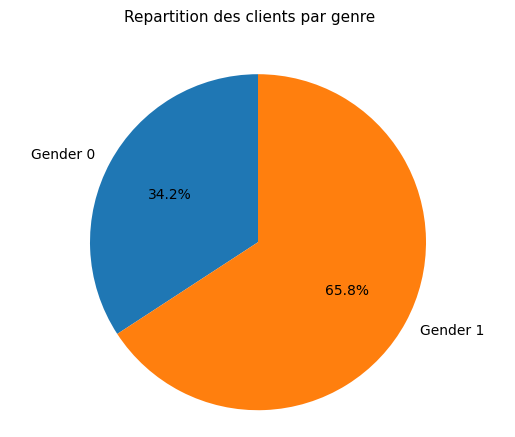

In [96]:
fig, ax = plt.subplots()
ax.pie(X_train['CODE_GENDER'].value_counts(ascending=True),  labels=['Gender 0' ,'Gender 1'], autopct='%1.1f%%',startangle=90)
ax.axis('equal')
fig.suptitle('Repartition des clients par genre', fontsize=11)

plt.savefig('genre.png')
plt.show()

### Situation d'un client  par rapport a la distribution des clients par feature et par genre pour les top 10 features

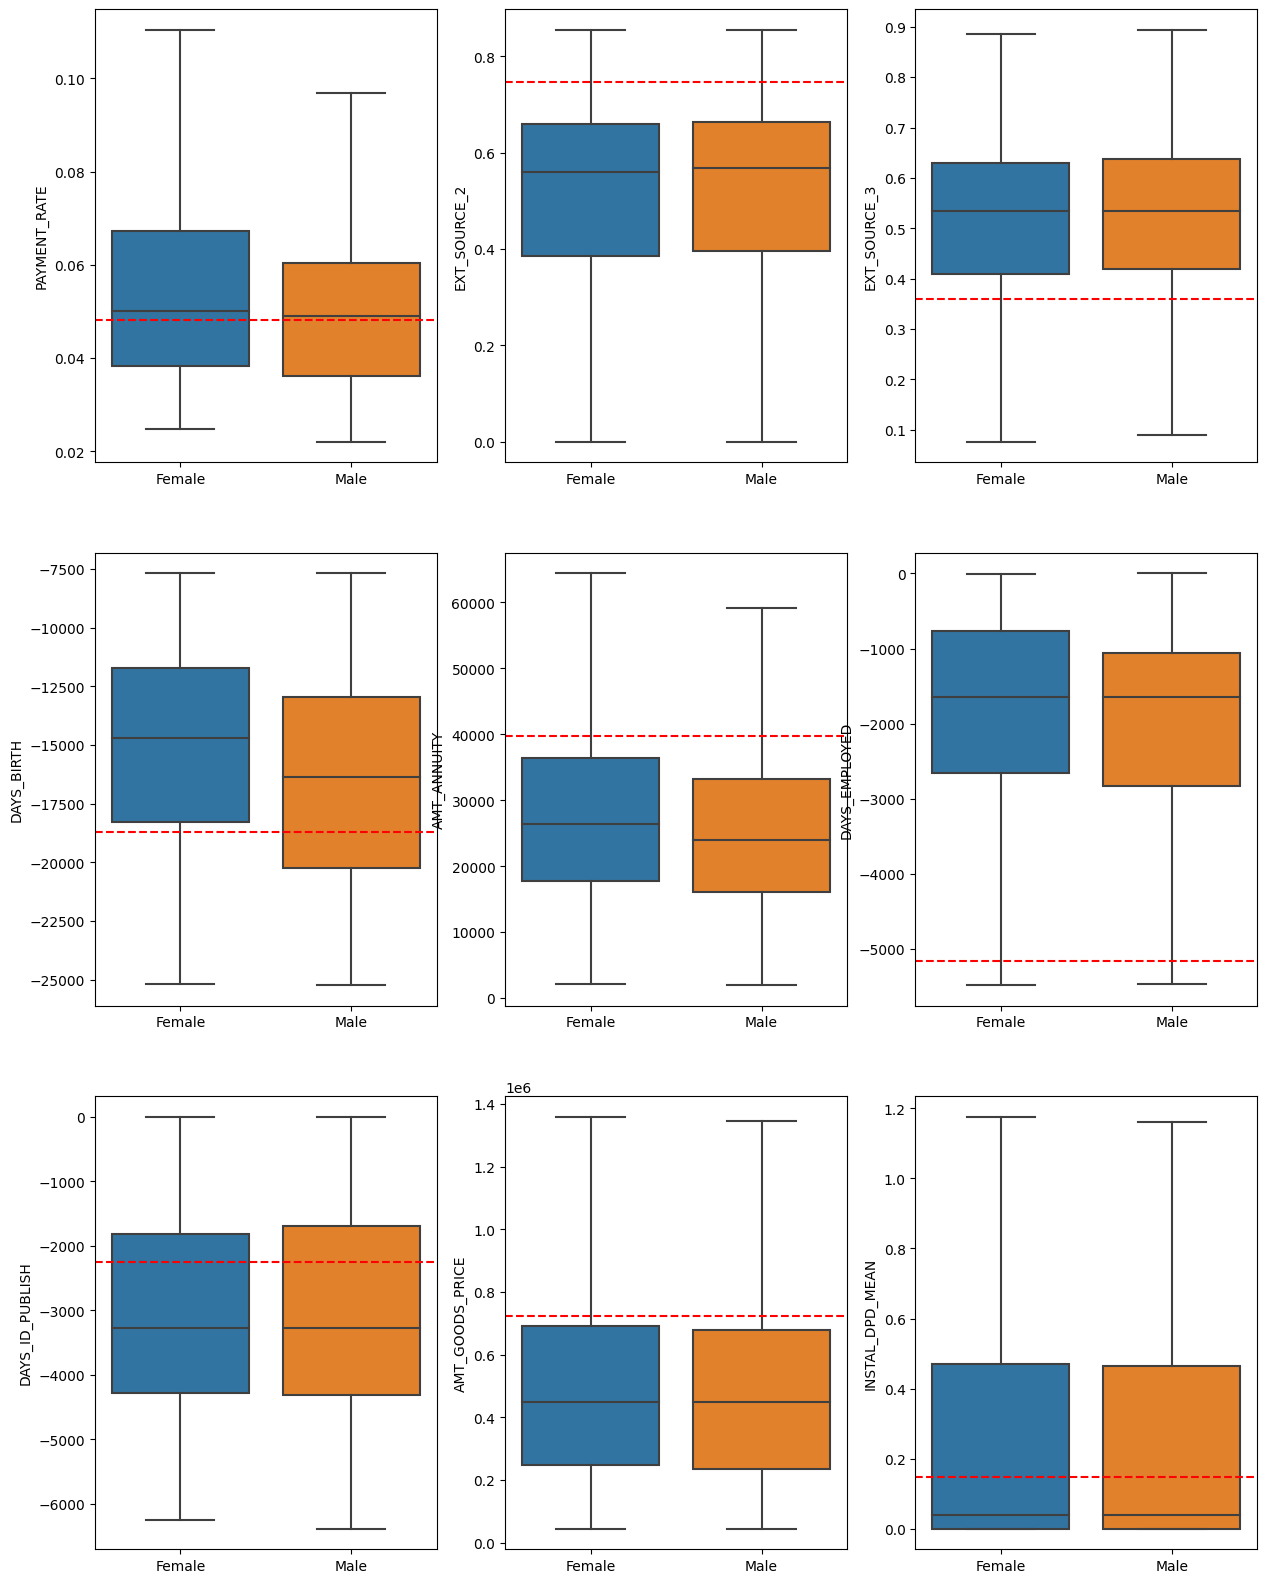

In [86]:
top9_feat=np.delete(top10_feat,-1)
fig, axes = plt.subplots(3,3, figsize=(15,20)) # create figure and axes
client=df.loc[3]
for i,el in enumerate(list(top9_feat)):
    ax=axes.flatten()[i]
    a = sns.boxplot(y=el, x='CODE_GENDER', data=X_test,showfliers = False, ax=ax)
    ax.axhline(y=client[el], c='red', ls='--') 
    labels = ['Female', 'Male']
    ax.set_xticklabels(labels)
    ax.set_xlabel('')
plt.savefig('gender_boxplot.png')
       
plt.show()


### Situation d'un client  par rapport a la distribution des clients par feature  pour les top 10 features

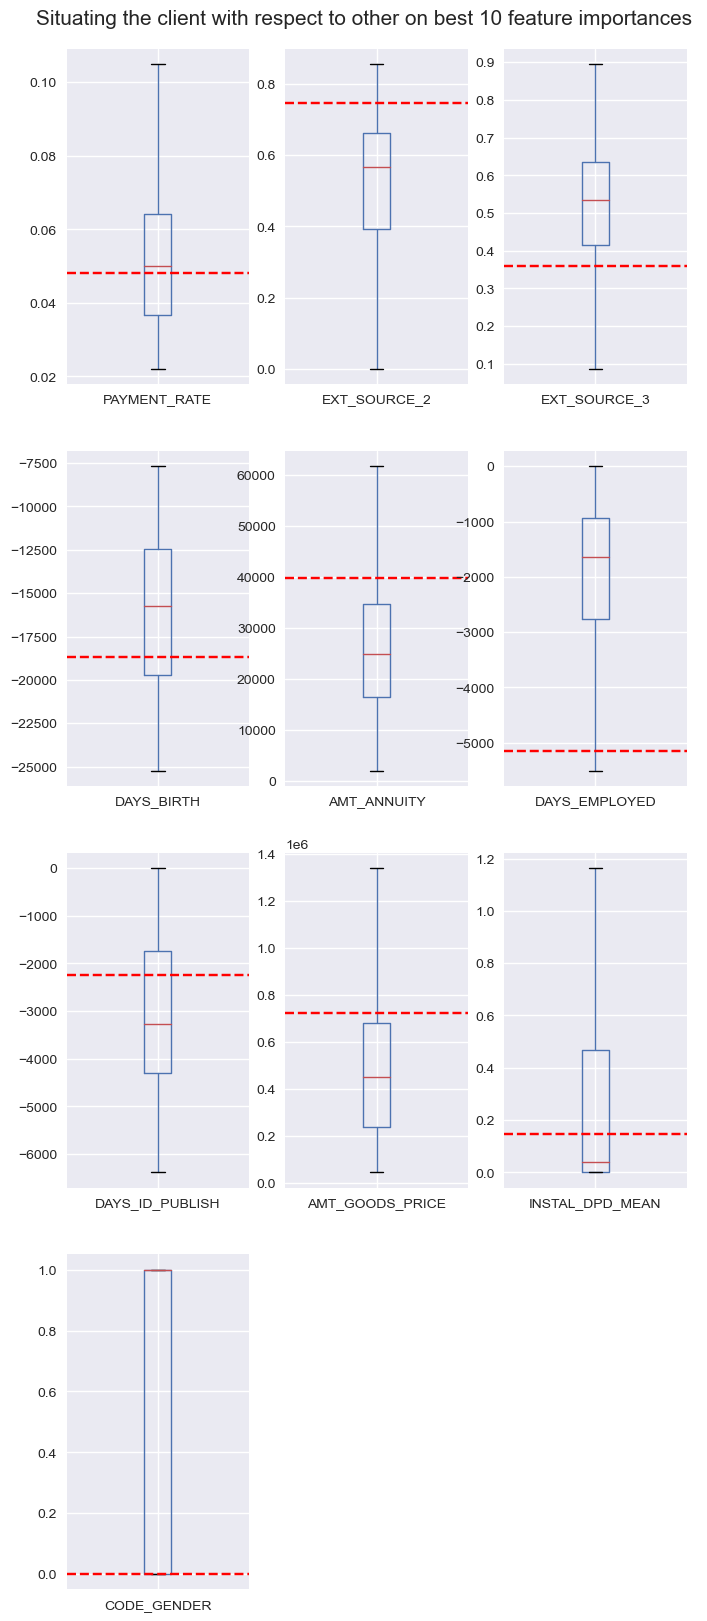

In [99]:
fig, axes = plt.subplots(4,3, figsize=(8,20)) # create figure and axes
client=df.loc[3]
for i,el in enumerate(list(top10_feat)):
    ax=axes.flatten()[i]
    a = df.boxplot(el, ax=ax, showfliers=False)
    ax.axhline(y=client[el], c='red', ls='--') 
fig.suptitle("Situating the client with respect to other on best 10 feature importances ",
                 size=15,
                 y=0.9)
fig.delaxes(axes[3][2])
fig.delaxes(axes[3][1])

plt.show()

## 4- Prediction de la classe du client en utilisant le seuil optimal du modele

In [65]:
# index du client connaissant son identifiant SK_ID_CURR
idx=int(df[df["SK_ID_CURR"]==271981].index.values)
idx

4

In [68]:
# probabilite des classes
client_prob=model.predict_proba(X_test[X_test.index==idx])
client_prob

array([[0.78320794, 0.21679206]])

In [59]:
# Prediction de la classe du client en utilisant le seuil optimal du modele
y_pred=(client_prob[:,1]>best_th).astype('int')

In [62]:
 int(y_pred.astype('int'))

0

In [102]:
client_probability=model.predict_proba(X_test.loc[1].values.reshape(1,-1))
client_probability

array([[0.8702326, 0.1297674]])

In [103]:
client_probability=client_probability.flat[1]

In [104]:
client_probability

0.1297674021810032

### Visualisation du score de la decision
Afin de mieux comprendre la situation du client, on represente graphiquement le score de la prediction, en general plus le score est lio du seuil plus la decision est precise

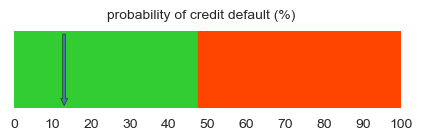

In [105]:
import matplotlib
from matplotlib.patches import Rectangle, FancyArrowPatch
#plt.style.use('default')
fig, ax = plt.subplots(figsize=(5, 1))
fig.suptitle("probability of credit default (%)",
                 size=10,
                 y=1.1)
ax.add_patch(Rectangle((0, 0), width=best_th * 100, height=1, color='limegreen'))
ax.add_patch(Rectangle((best_th * 100, 0), width=100 - best_th * 100, height=1, color='orangered'))
#ax.plot(mapmatplotlib.patches.Rectangle() * 100, best_th * 100), (0, 1),
           # color='#FF8C00',
           # ls=(0, (0.5, 0.5)),
           # lw=6)
ax.add_patch(FancyArrowPatch((client_probability * 100, 1), (client_probability * 100, 0), mutation_scale=10))
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
ax.set_xticks(range(0, 105, 10))
ax.set_yticks([])
plt.show()
#st.pyplot(fig)


## 5- Representation de l'information du client par rapport a la vrai distribution des clients 

In [106]:
df0 = df[top10_feat].loc[df['TARGET'] == 0]
df1 = df[top10_feat].loc[df['TARGET'] == 1]

#### Remarque
On utilisera les jeux de donnees df0 et df1 afin de reduire le temps de calcul sur l'API

In [107]:
df0.to_csv('df0.csv', index=False)
df1.to_csv('df1.csv', index=False)

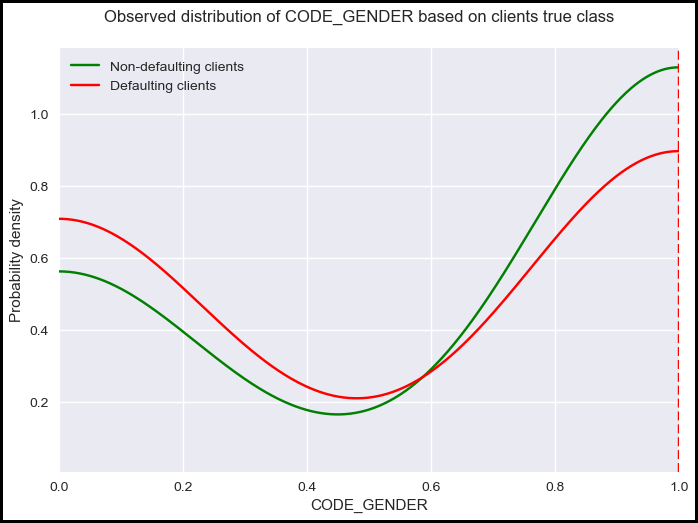

In [110]:
feature='CODE_GENDER'
client_feat=df.loc[100][feature]
bw_method=0.5

xmin = minmax[feature].values[0]
xmax = minmax[feature].values[4]
    # Plotting
plt.style.use('seaborn')
fig = plt.figure(edgecolor='black', linewidth=4, dpi=100)
g=df0[feature].plot(kind='kde',
                   c='g',
                   label='Non-defaulting clients',
                   bw_method=bw_method,
                   ind=None)
df1[feature].plot(kind='kde',
                   c='r',
                   label='Defaulting clients',
                   bw_method=bw_method,
                   ind=None)
ax=g.axes
ax.axvline(client_feat, ls='--', color='r')
fig.suptitle(
        f'Observed distribution of {feature} based on clients true class',
        y=0.95)
plt.legend()
plt.xlabel(feature)
plt.ylabel('Probability density')
plt.xlim(xmin, xmax)
plt.show()

## 6- Interpretabilite du modele : Shap

In [13]:
import shap

shap.initjs()
explainer= shap.TreeExplainer(model)

In [14]:
X=X_test.sample(1000)

In [17]:
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [18]:
explainer.expected_value

[0.5630267326199972, -0.5630267326199972]

In [19]:
pickle.dump((explainer,shap_values, X),open('explainer_shap_values_X_lightgbm.pkl','wb'))


### A- Interpretabilite globale

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


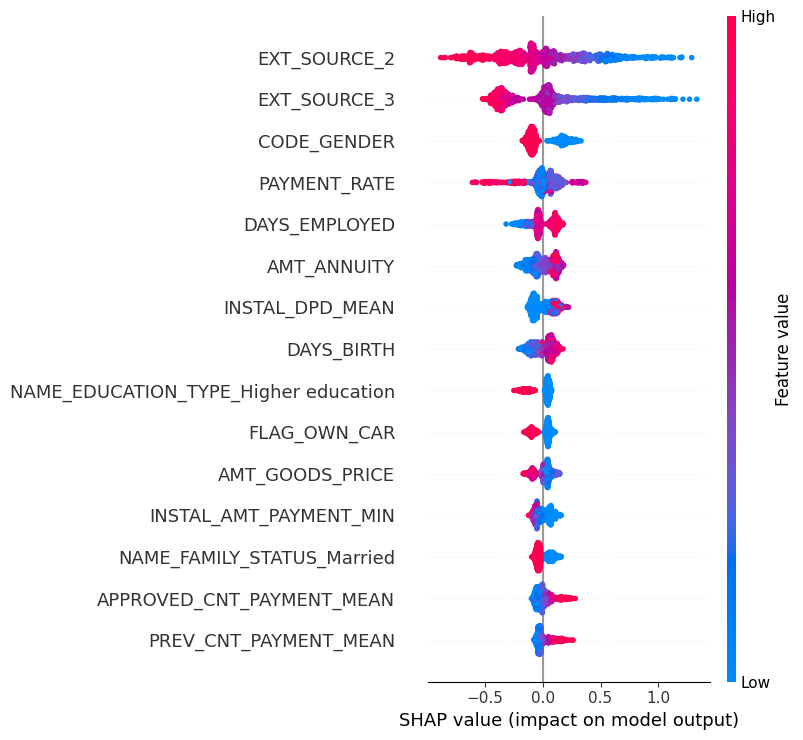

In [94]:
shap.summary_plot(shap_values[1], X, max_display=15, show=False)
plt.savefig('summary_plot.png')

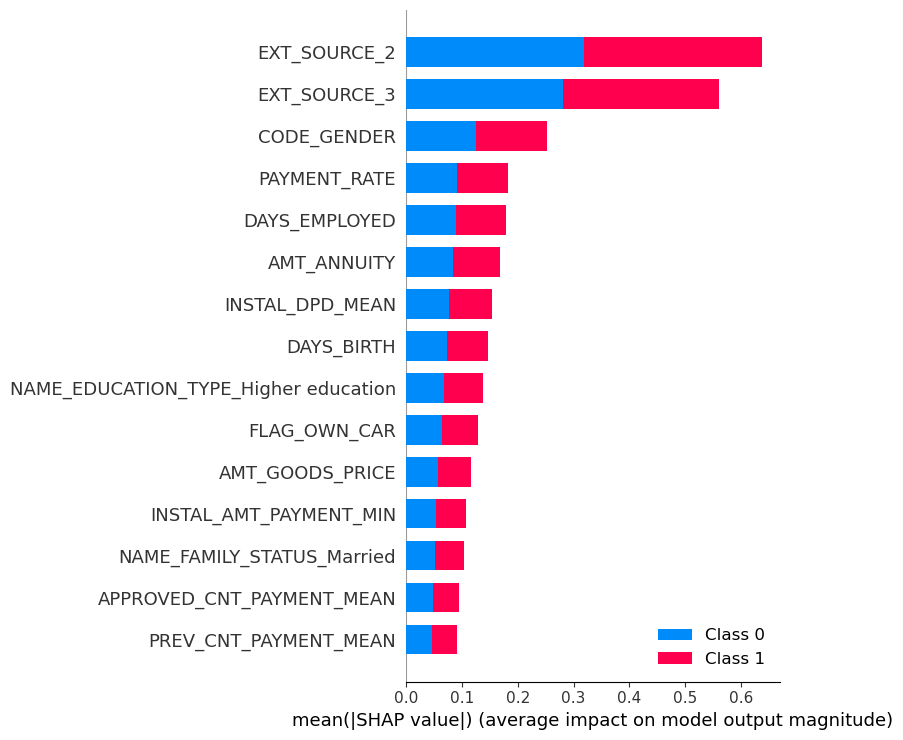

In [21]:
shap.summary_plot(shap_values, X,  max_display=15,show=False)
plt.savefig('summary_plot_mean.png')

### B- Interpretabilite locale

In [34]:
X_display=X_test.columns

In [38]:
shap_values = explainer.shap_values(X_test[X_test.index==1])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [39]:
expected=float(explainer.expected_value[0])
expected

0.5630267326199972

### Force plot

In [41]:
shap.force_plot(expected, shap_values[1], X_display)


### Waterfall plot

In [51]:
explanation=(shap.Explanation(base_values=expected, values=shap_values[1][0],  
                              data=X_test.loc[1], feature_names=X_display))

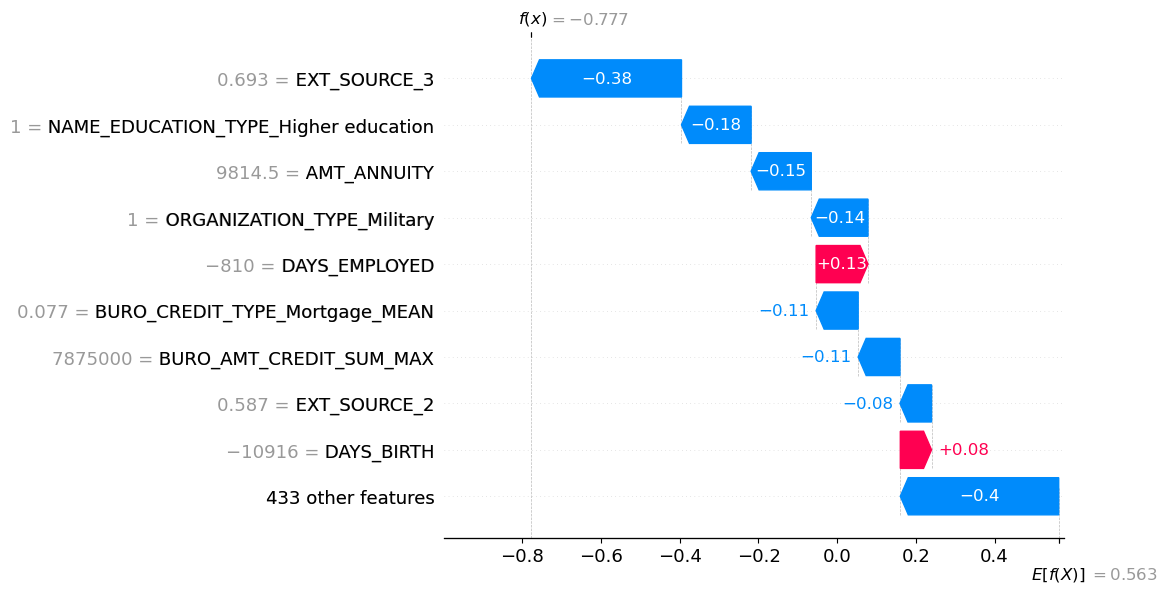

In [52]:
plot=shap.waterfall_plot(explanation, max_display=10)